In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [255]:
# importing Data
data = pd.read_excel('laptop_price.xlsx')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


## Preparation of data

In [256]:
# Clean Data
# The product is not useful so take the column out
data = data.drop(['laptop_ID','Product'],axis = 1)
data = data.drop_duplicates()

In [257]:
data.isnull().sum()
# there is no is null values in any variables, hence no need to filter out the rows with null values

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

In [258]:
# Take out the width n height from screen resolution
data['ScreenResolution'] = data['ScreenResolution'].str.split(' ').apply(lambda x: x[-1]) 
#split by space and take the final index str
data['ScreenResolution'] = data['ScreenResolution'].str.split('x').apply(lambda x: int(x[0])*int(x[1]))

In [259]:
# split the CPU
data['CPU_company'] = data['Cpu'].str.split(' ').apply(lambda x: x[0])
data['CPU_MODEL'] = data['Cpu'].str.split(' ',1).apply(lambda x: x[1])
data['CPU_speed'] = data['CPU_MODEL'].str.split(' ').apply(lambda x: float(x[-1].replace('GHz',' ')))
data['CPU_MODEL'] = data['CPU_MODEL'].str.split(' ').apply(lambda x: x[1] if x[0] == 'Core' else ' '.join(x[0:-1]))
data = data.drop(['Cpu'],axis = 1)

In [260]:
# Take out the GB in RAM 
data['Ram'] = data['Ram'].str.replace("GB","")
data['Ram'].astype(int)
data['Weight'] = data['Weight'].str.replace("kg","")
data['Weight'].astype(float)

0       1.37
1       1.34
2       1.86
3       1.83
4       1.37
        ... 
1269    2.20
1270    1.80
1271    1.30
1272    1.50
1273    2.19
Name: Weight, Length: 1274, dtype: float64

In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1274 entries, 0 to 1273
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1274 non-null   object 
 1   TypeName          1274 non-null   object 
 2   Inches            1274 non-null   float64
 3   ScreenResolution  1274 non-null   int64  
 4   Ram               1274 non-null   object 
 5   Memory            1274 non-null   object 
 6   Gpu               1274 non-null   object 
 7   OpSys             1274 non-null   object 
 8   Weight            1274 non-null   object 
 9   Price_euros       1274 non-null   float64
 10  CPU_company       1274 non-null   object 
 11  CPU_MODEL         1274 non-null   object 
 12  CPU_speed         1274 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 139.3+ KB


In [262]:
# Clean GPU data
# There is too many different kind of GPU hence we only take the company as reference
data['Gpu'] = data['Gpu'].str.split(' ').apply(lambda x: x[0])
data.head()
data['Gpu'].value_counts()

# Since there is only 1 ARM here, the data might not be accurate, hence will take out this row
data = data.loc[data["Gpu"]!='ARM']

In [263]:
# Clean Memory data
data['Memory'].value_counts()

256GB SSD                        412
1TB HDD                          215
500GB HDD                        123
512GB SSD                        114
128GB SSD +  1TB HDD              94
128GB SSD                         74
256GB SSD +  1TB HDD              73
32GB Flash Storage                35
2TB HDD                           16
512GB SSD +  1TB HDD              14
1TB SSD                           14
64GB Flash Storage                13
256GB SSD +  2TB HDD              10
256GB Flash Storage                8
16GB Flash Storage                 7
1.0TB Hybrid                       7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [264]:
def memory_seperation(string,dtype):
    li = []
    temp = string.split('+')
    for x in temp:
        split = x.split(' ')
        for i in range(len(split)):
            if(split[i]==dtype):
                return [split[i-1],split[i]]
    return ['0GB']
    

In [265]:
for x in ['SSD','HDD','Flash','Hybrid']: 
    data[x] = data['Memory'].apply(memory_seperation,args = [x]).apply(lambda x: float(x[0][0:-2]) if x[0][-2:] =='GB' else float(x[0][0:-2])*1024)
    data[x] = data[x].astype(int)
data = data.drop(['Memory'],axis = 1)
data.head()

,Company,TypeName,Inches,ScreenResolution,Ram,Gpu,OpSys,Weight,Price_euros,CPU_company,CPU_MODEL,CPU_speed,SSD,HDD,Flash,Hybrid
0,Apple,Ultrabook,13.3,4096000,8,Intel,macOS,1.37,1339.69,Intel,i5,2.3,128,0,0,0
1,Apple,Ultrabook,13.3,1296000,8,Intel,macOS,1.34,898.94,Intel,i5,1.8,0,0,128,0
2,HP,Notebook,15.6,2073600,8,Intel,No OS,1.86,575.00,Intel,i5,2.5,256,0,0,0
3,Apple,Ultrabook,15.4,5184000,16,AMD,macOS,1.83,2537.45,Intel,i7,2.7,512,0,0,0
4,Apple,Ultrabook,13.3,4096000,8,Intel,macOS,1.37,1803.60,Intel,i5,3.1,256,0,0,0


In [266]:
i = data['CPU_MODEL'].unique()
#i
li = []
for x in i:
    temp = sum(data['CPU_MODEL']==x)
    if(temp>10):
        li.append(x)
li
    
# maybe try to take out the model with lesser data set to only the company

['i5',
 'i7',
 'A9-Series 9420',
 'i3',
 'M',
 'Celeron Dual Core N3350',
 'Pentium Quad Core N4200',
 'Celeron Dual Core N3060',
 'Pentium Quad Core N3710']

In [267]:
data['CPU_MODEL'] = data['CPU_MODEL'].apply(lambda x: x if x in li else "others")
data['ScreenResolution'] = data['ScreenResolution']/1000
data

,Company,TypeName,Inches,ScreenResolution,Ram,Gpu,OpSys,Weight,Price_euros,CPU_company,CPU_MODEL,CPU_speed,SSD,HDD,Flash,Hybrid
0,Apple,Ultrabook,13.3,4096.000,8,Intel,macOS,1.37,1339.69,Intel,i5,2.3,128,0,0,0
1,Apple,Ultrabook,13.3,1296.000,8,Intel,macOS,1.34,898.94,Intel,i5,1.8,0,0,128,0
2,HP,Notebook,15.6,2073.600,8,Intel,No OS,1.86,575.00,Intel,i5,2.5,256,0,0,0
3,Apple,Ultrabook,15.4,5184.000,16,AMD,macOS,1.83,2537.45,Intel,i7,2.7,512,0,0,0
4,Apple,Ultrabook,13.3,4096.000,8,Intel,macOS,1.37,1803.60,Intel,i5,3.1,256,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,Asus,Notebook,15.6,1049.088,4,Nvidia,Windows 10,2.2,720.32,Intel,i7,2.5,0,500,0,0
1270,Lenovo,2 in 1 Convertible,14.0,2073.600,4,Intel,Windows 10,1.8,638.00,Intel,i7,2.5,128,0,0,0
1271,Lenovo,2 in 1 Convertible,13.3,5760.000,16,Intel,Windows 10,1.3,1499.00,Intel,i7,2.5,512,0,0,0
1272,Lenovo,Notebook,14.0,1049.088,2,Intel,Windows 10,1.5,229.00,Intel,others,1.6,0,0,64,0


## EDA

### Uni-Variabte Statisitcs

<AxesSubplot:xlabel='Hybrid', ylabel='Count'>

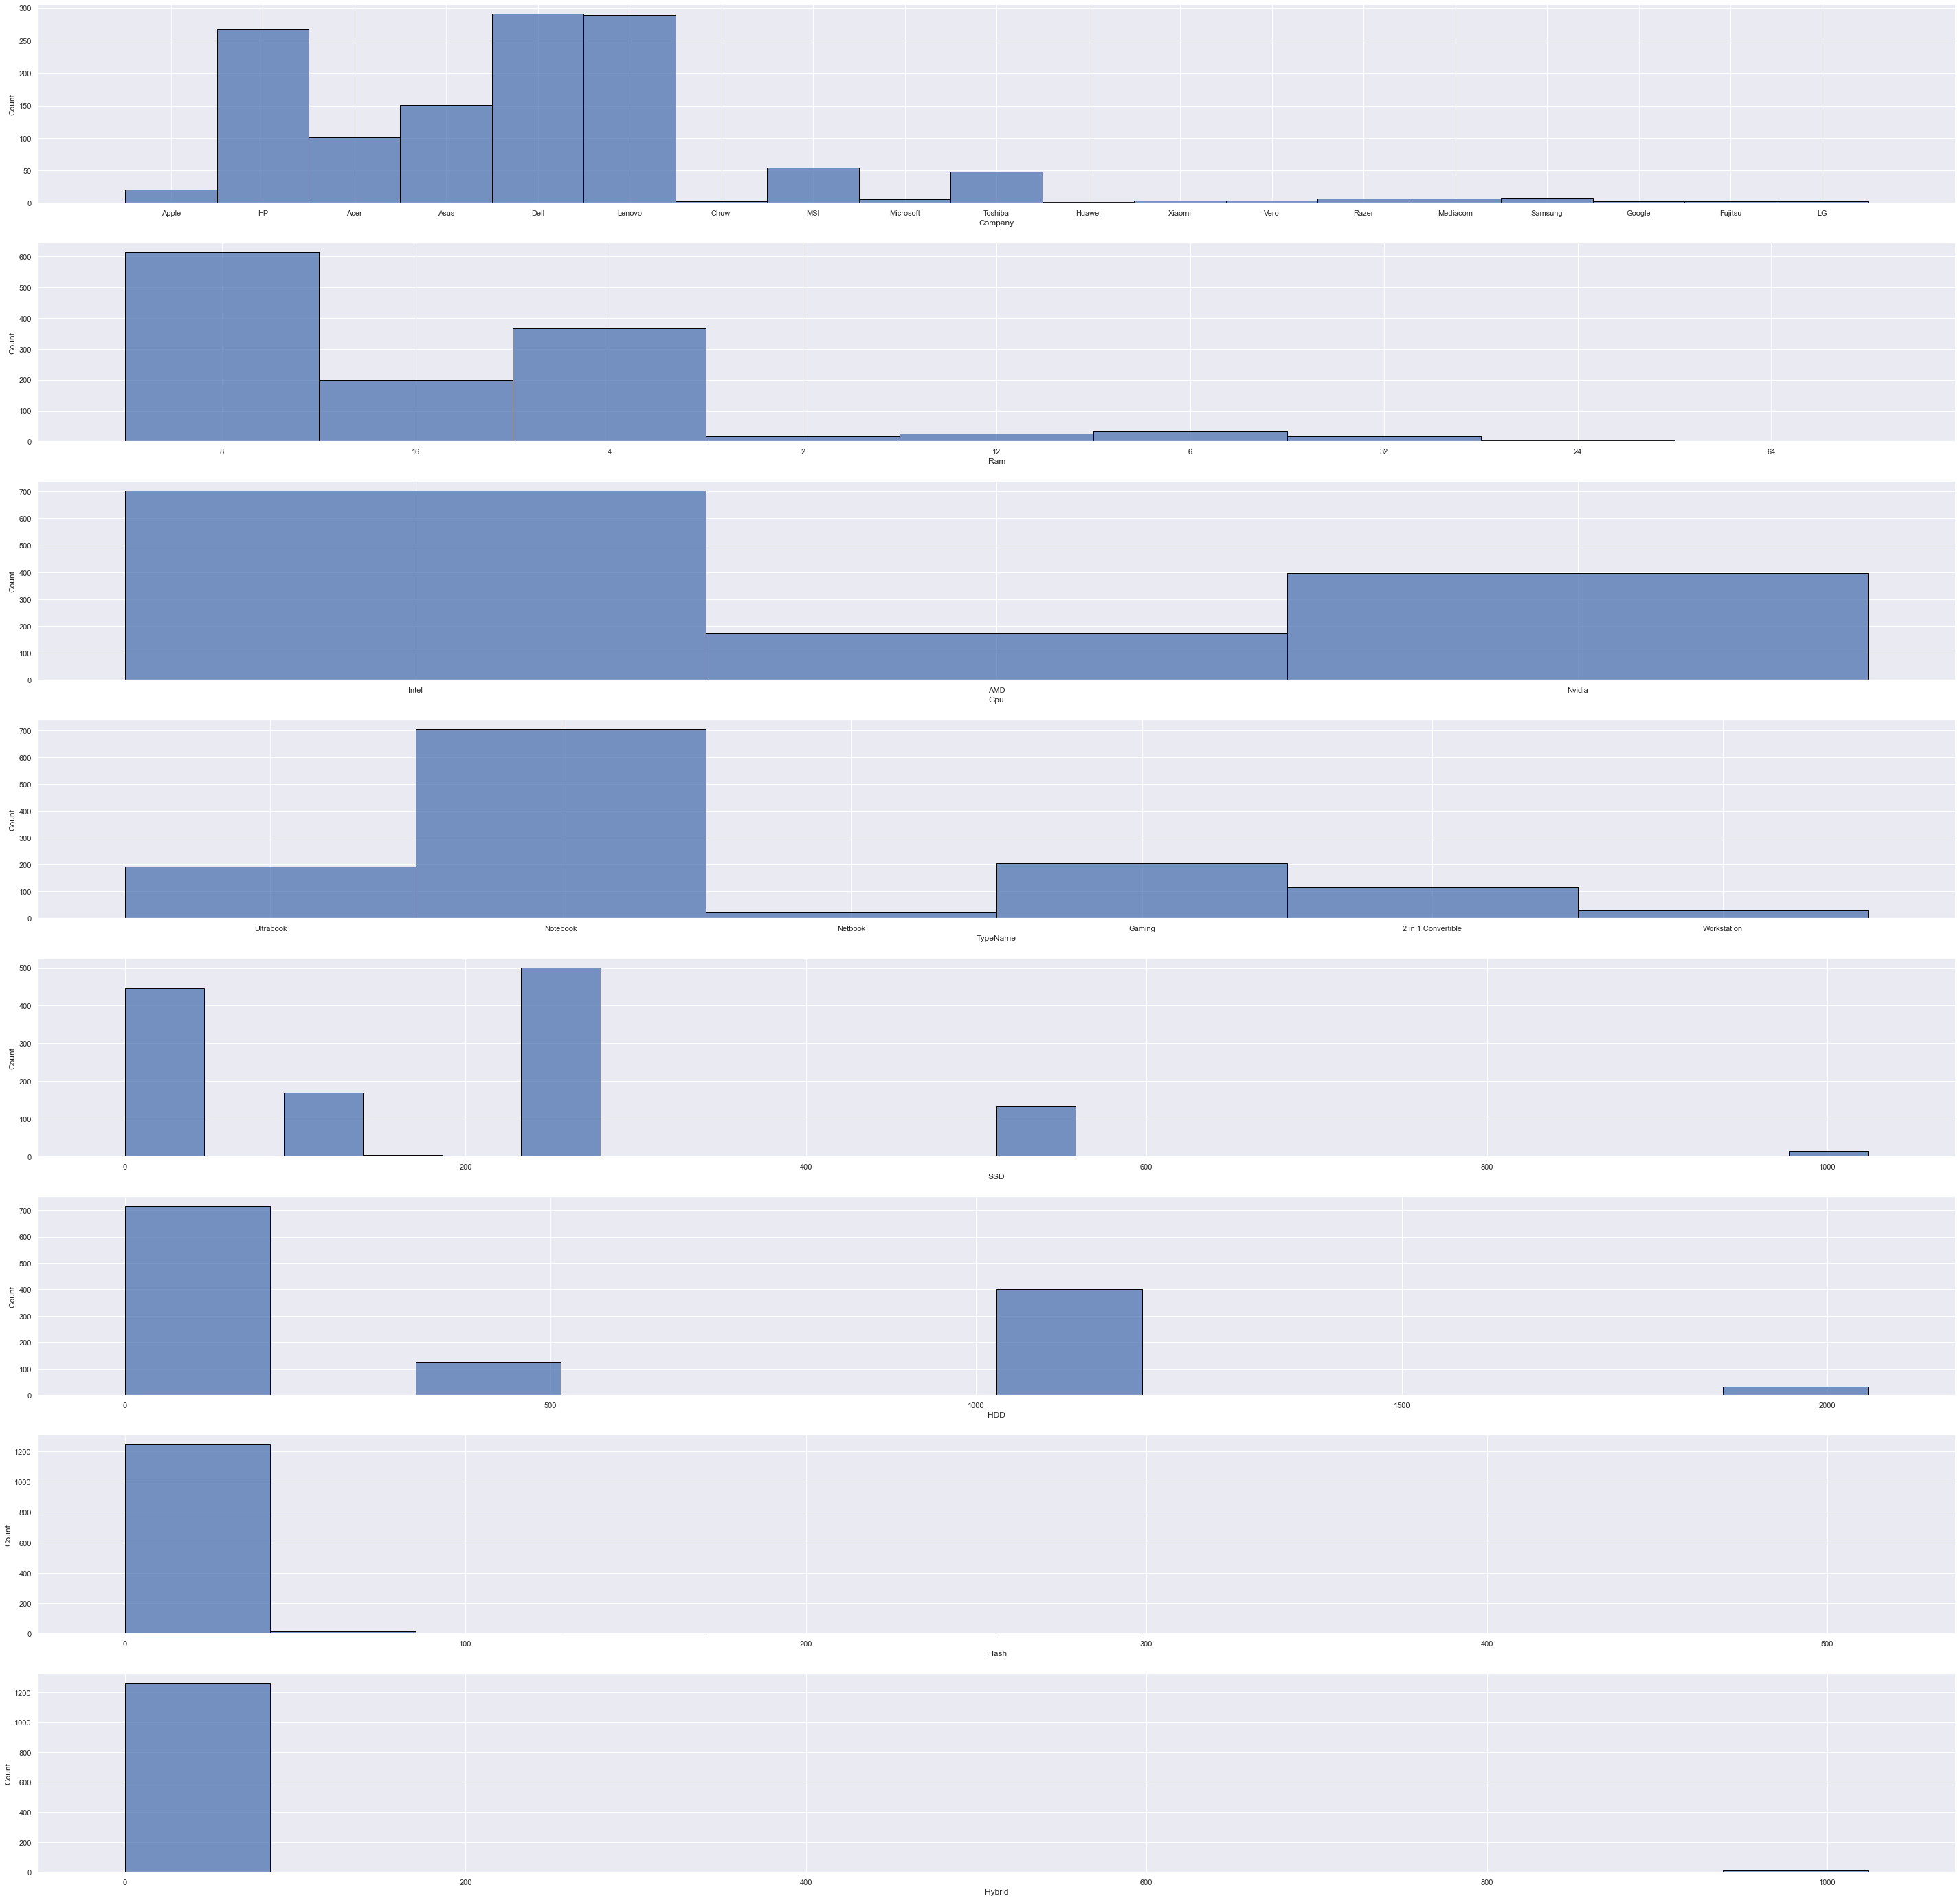

In [268]:
f, axes = plt.subplots(8,figsize=(50, 50))
sb.histplot(data = data['Company'], ax = axes[0],edgecolor='black')
sb.histplot(data = data['Ram'],ax = axes[1],edgecolor='black')
sb.histplot(data = data['Gpu'],ax = axes[2],edgecolor='black')
sb.histplot(data = data['TypeName'],ax = axes[3],edgecolor='black')
sb.histplot(data = data['SSD'],ax = axes[4],edgecolor='black')
sb.histplot(data = data['HDD'],ax = axes[5],edgecolor='black')
sb.histplot(data = data['Flash'],ax = axes[6],edgecolor='black')
sb.histplot(data = data['Hybrid'],ax = axes[7],edgecolor='black')

In [269]:
data['Hybrid'].value_counts()
# Most of the the memory are not hybrid, only 10 data with hybrid memory so keep or remove, Not many data in HDD and Flash
data['Flash'].value_counts()

0      1203
32       35
64       14
256       8
16        7
128       4
512       2
Name: Flash, dtype: int64

<AxesSubplot:xlabel='CPU_MODEL', ylabel='Count'>

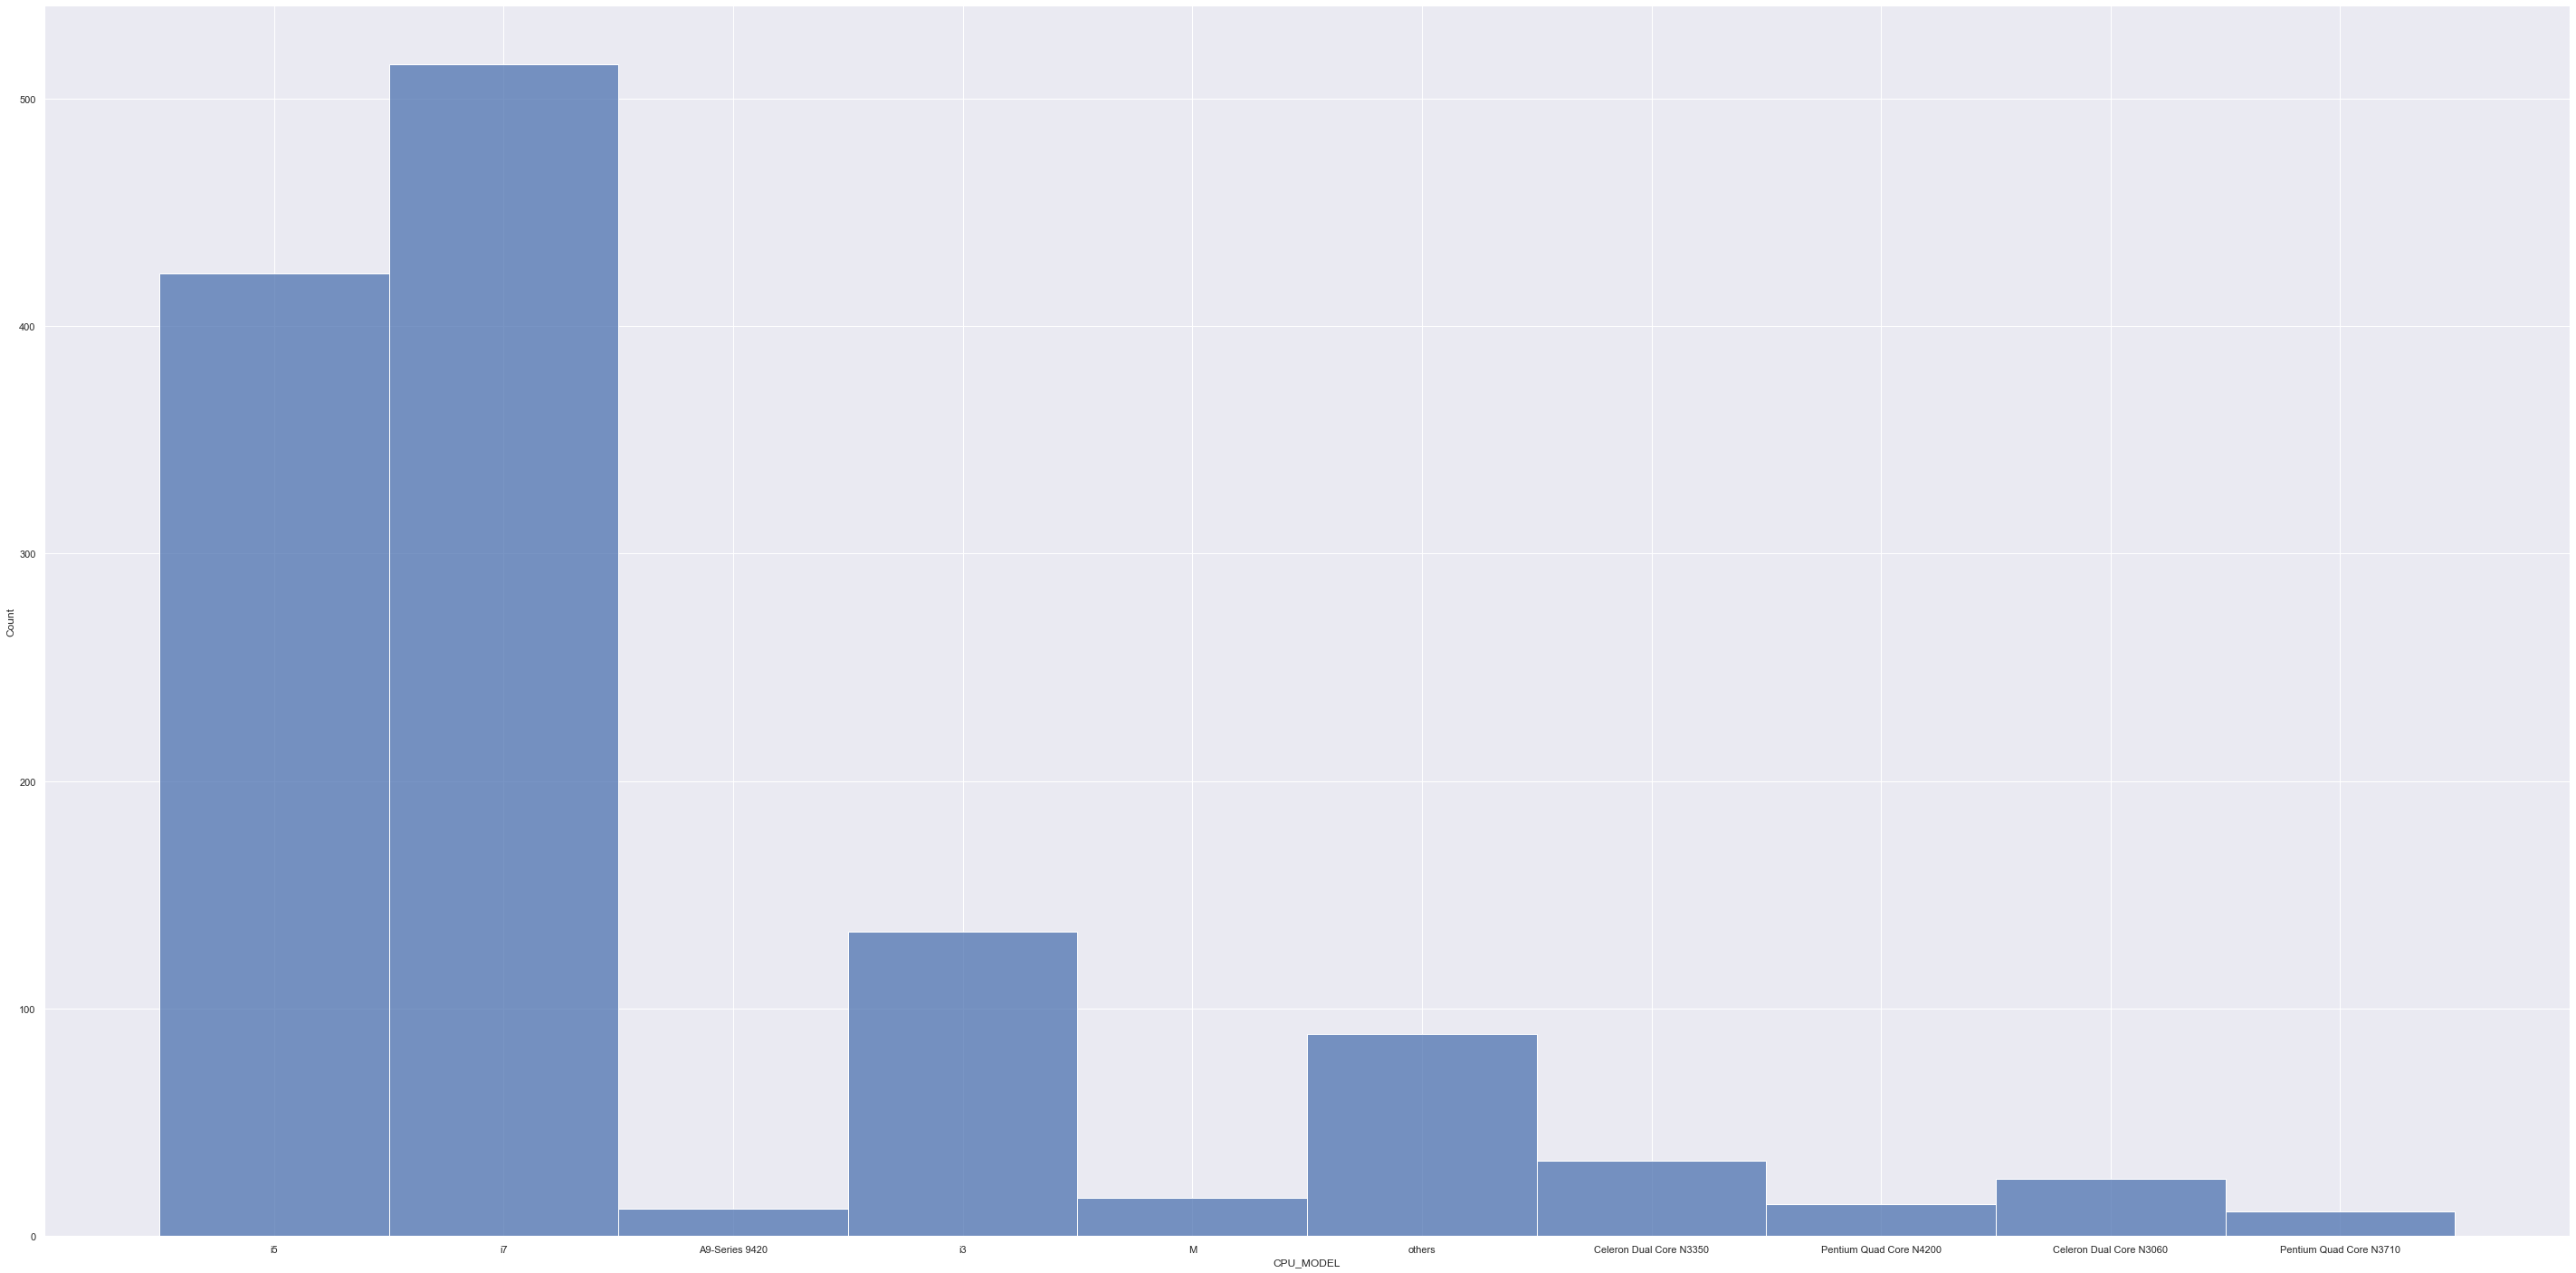

In [270]:
f = plt.figure(figsize=(50, 25))
sb.histplot(data = data['CPU_MODEL'])

<AxesSubplot:>

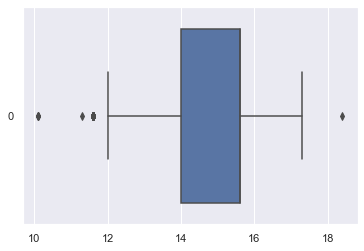

In [271]:
sb.boxplot(data = data['Inches'], orient = "h")
# with outliers, take out or not

<AxesSubplot:>

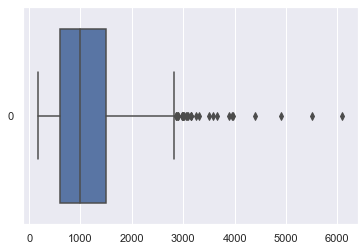

In [272]:
sb.boxplot(data = data['Price_euros'], orient = "h")

<AxesSubplot:>

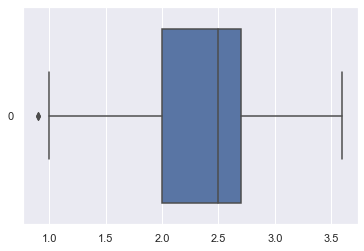

In [273]:
sb.boxplot(data = data['CPU_speed'], orient = "h")

<AxesSubplot:xlabel='ScreenResolution', ylabel='Count'>

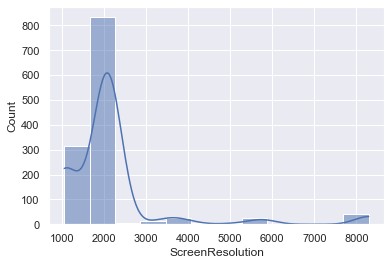

In [274]:
sb.histplot(data = data['ScreenResolution'], kde = True)

<AxesSubplot:>

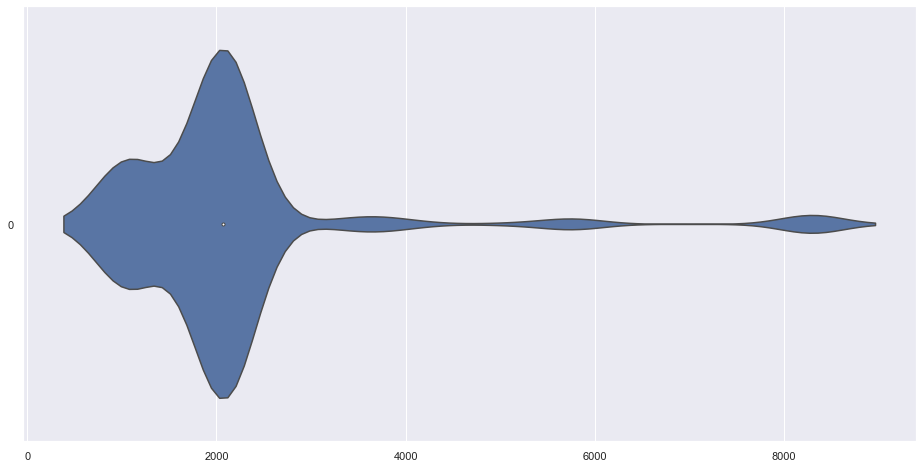

In [275]:
f = plt.figure(figsize=(16, 8))
sb.violinplot(data = data['ScreenResolution'], orient = "h")

In [276]:
data.corr()

,Inches,ScreenResolution,Price_euros,CPU_speed,SSD,HDD,Flash,Hybrid
Inches,1.000000,-0.081751,0.066079,0.305310,-0.104818,0.529073,-0.226009,0.052297
ScreenResolution,-0.081751,1.000000,0.512444,0.130464,0.486508,-0.109583,0.002464,-0.010040
Price_euros,0.066079,0.512444,1.000000,0.427994,0.675158,-0.096180,-0.036712,0.022526
CPU_speed,0.305310,0.130464,0.427994,1.000000,0.269295,0.125899,-0.222967,0.048952
SSD,-0.104818,0.486508,0.675158,0.269295,1.000000,-0.396721,-0.147106,-0.049549
HDD,0.529073,-0.109583,-0.096180,0.125899,-0.396721,1.000000,-0.114238,-0.070116
Flash,-0.226009,0.002464,-0.036712,-0.222967,-0.147106,-0.114238,1.000000,-0.012931
Hybrid,0.052297,-0.010040,0.022526,0.048952,-0.049549,-0.070116,-0.012931,1.000000


## Multi-Variate

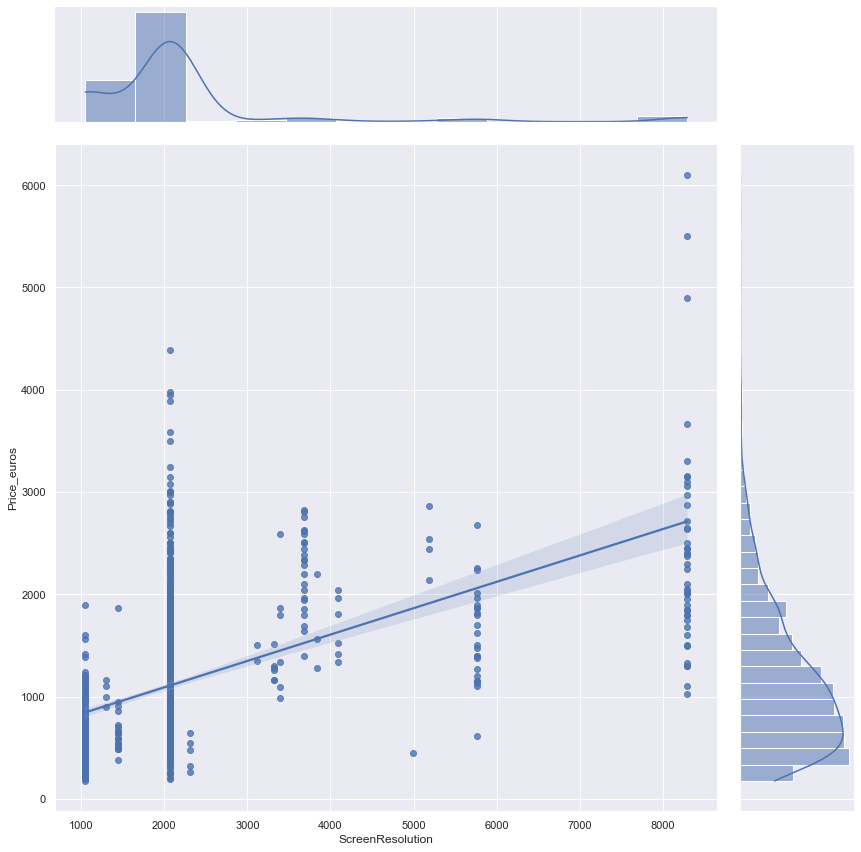

In [277]:
sb.jointplot(data = data, x = 'ScreenResolution',y = 'Price_euros', height = 12,kind='reg')

Company
TypeName
Ram
Gpu
OpSys
CPU_company
CPU_MODEL


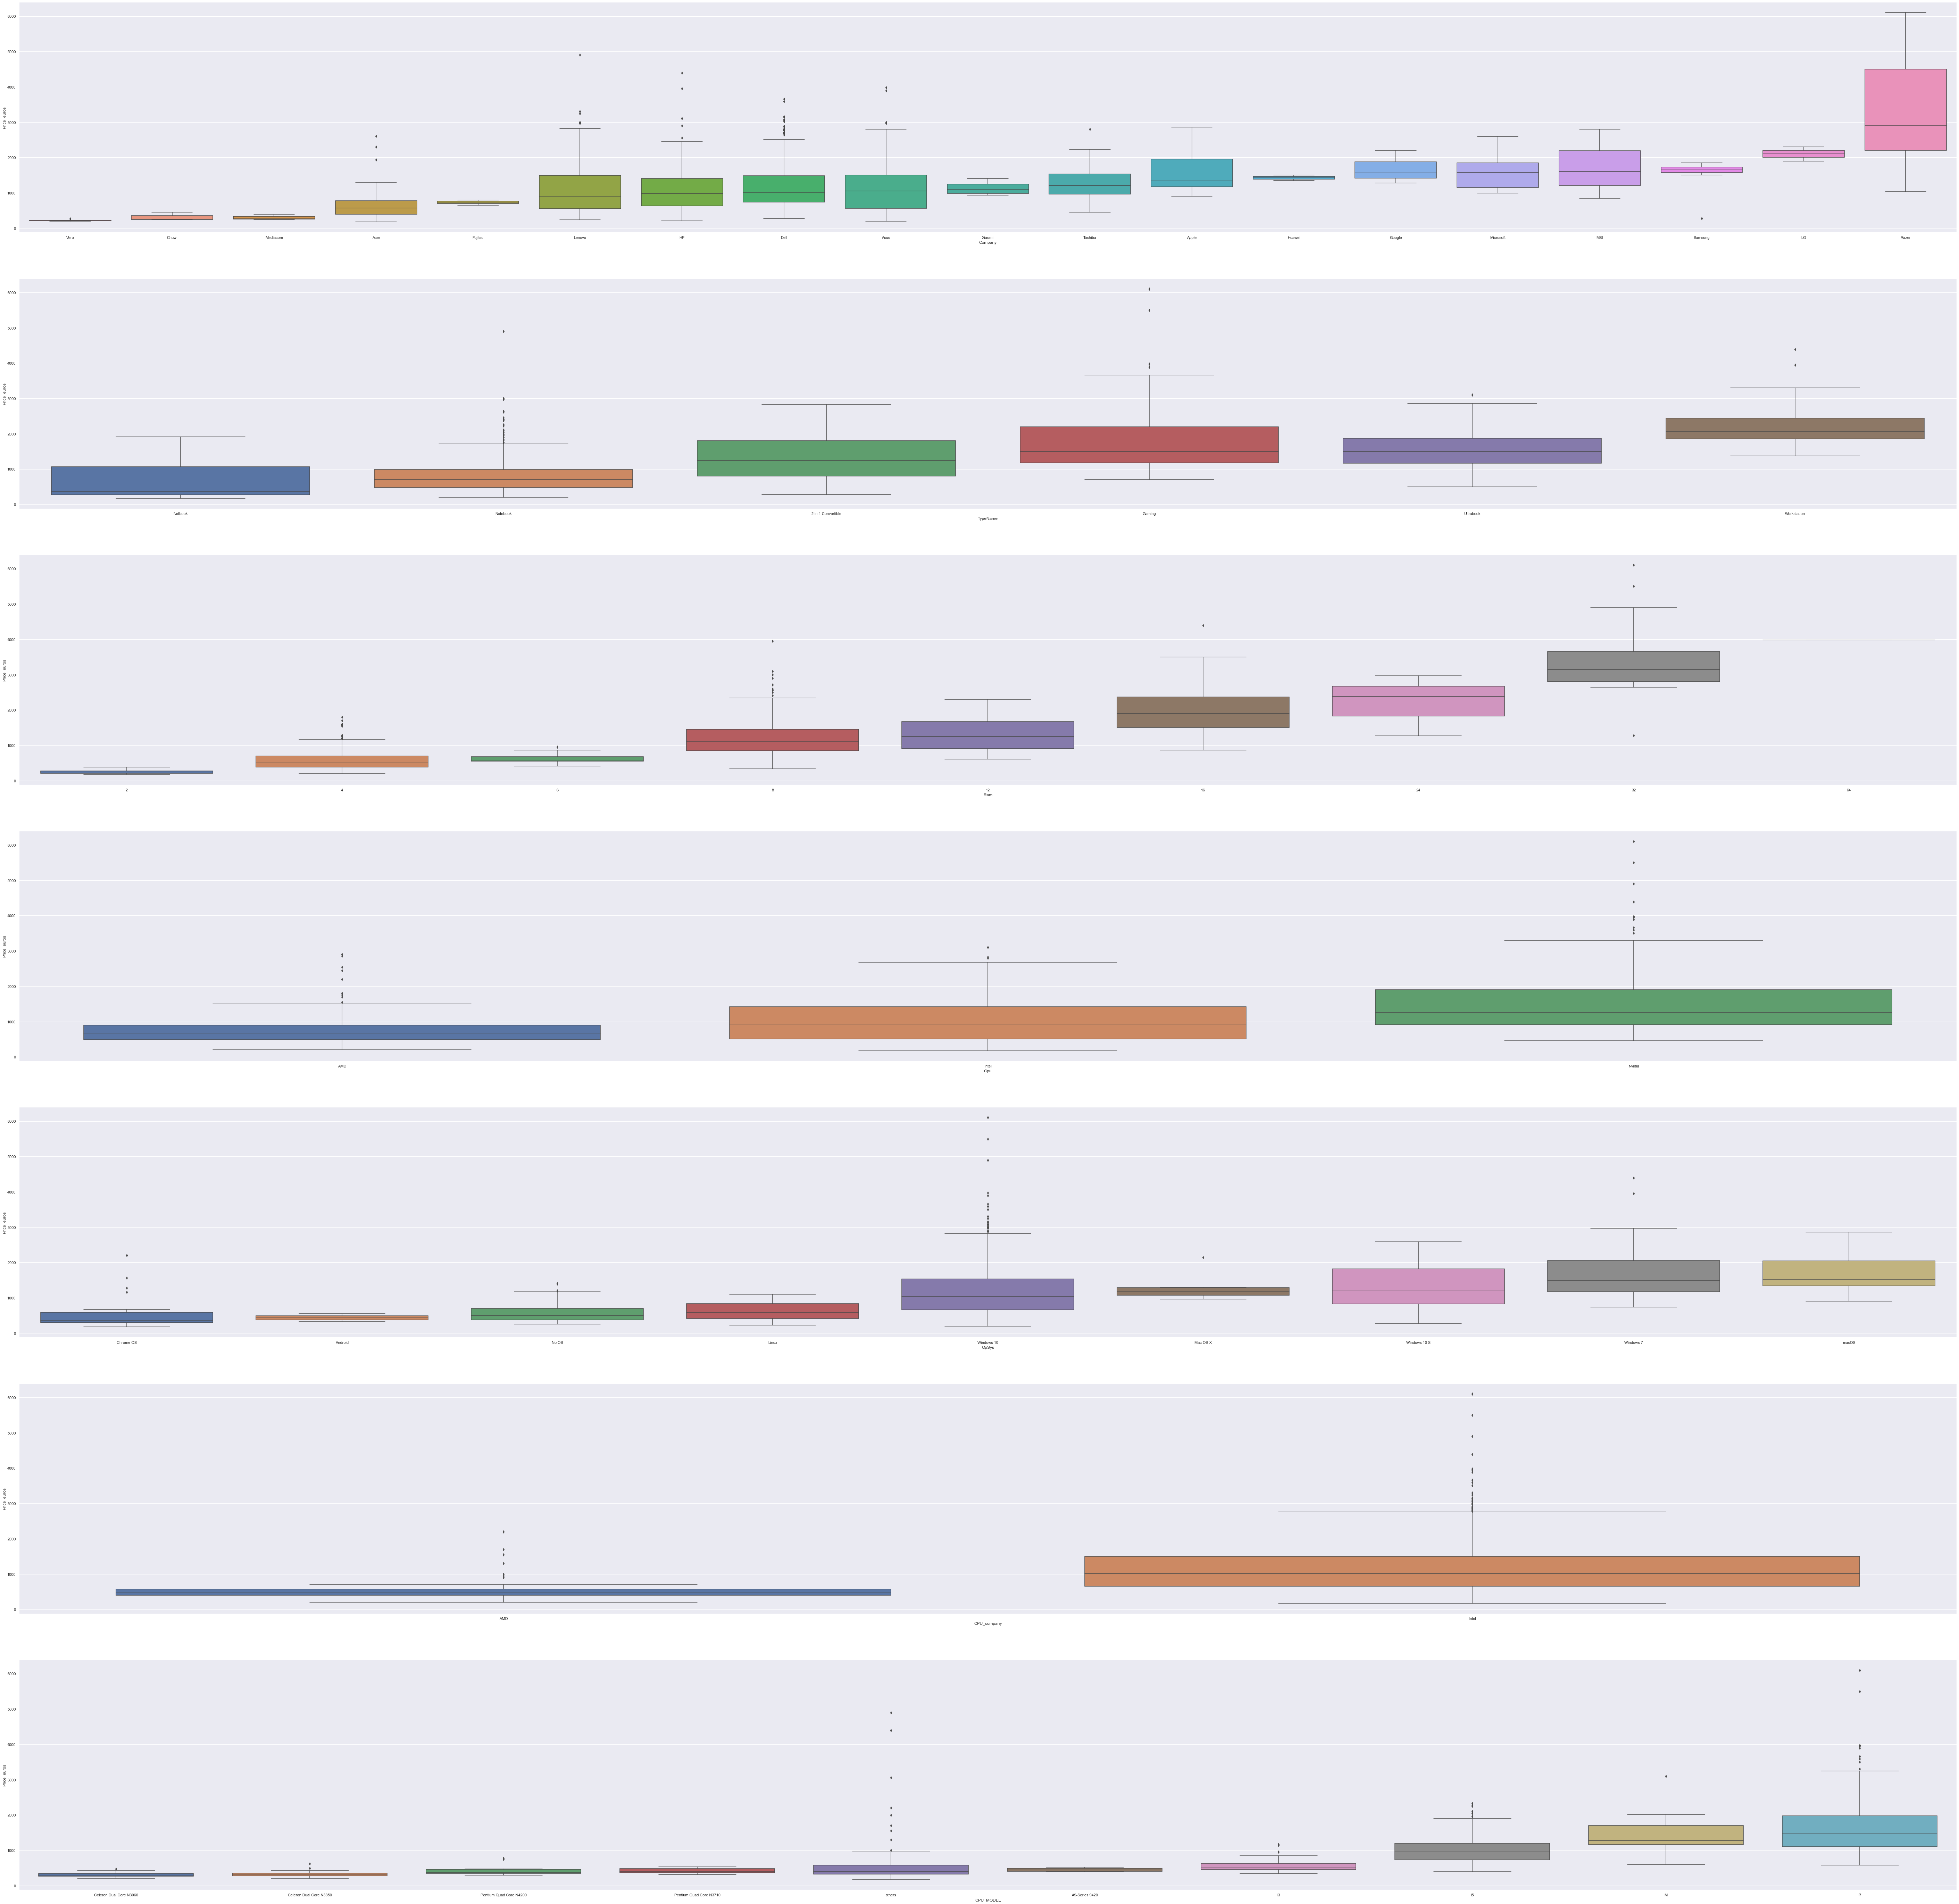

In [278]:
# Groupby function with some categorical data
f, axes = plt.subplots(7,figsize=(100, 100))
count = 0
catPred = ['Company','TypeName','Ram','Gpu','OpSys','CPU_company','CPU_MODEL']
for i in catPred:
    print(i)
    sb.boxplot(data = data, y = "Price_euros", x = i,ax = axes[count], order = data.groupby(i)['Price_euros'].median().sort_values().index)
    count+=1

In [279]:
# Categorical Data:[Company,Ram,CPU_company]
# Numeric Data: [SSD, Screenresolution]
CatData = pd.DataFrame(data[['Company','Ram','CPU_company','CPU_MODEL']])
NumData = pd.DataFrame(data[['SSD','ScreenResolution','Price_euros']])

In [280]:
type(data['Flash'].unique())

numpy.ndarray

In [281]:
# change categorical variables to dummy variables
CatData = pd.get_dummies(CatData, columns=['Company','Ram','CPU_company','CPU_MODEL'])
CatData


,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,Company_HP,Company_Huawei,Company_LG,...,CPU_MODEL_A9-Series 9420,CPU_MODEL_Celeron Dual Core N3060,CPU_MODEL_Celeron Dual Core N3350,CPU_MODEL_M,CPU_MODEL_Pentium Quad Core N3710,CPU_MODEL_Pentium Quad Core N4200,CPU_MODEL_i3,CPU_MODEL_i5,CPU_MODEL_i7,CPU_MODEL_others
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [282]:
Data = pd.concat([NumData,CatData],axis = 1)

In [283]:
Data

,SSD,ScreenResolution,Price_euros,Company_Acer,Company_Apple,Company_Asus,Company_Chuwi,Company_Dell,Company_Fujitsu,Company_Google,...,CPU_MODEL_A9-Series 9420,CPU_MODEL_Celeron Dual Core N3060,CPU_MODEL_Celeron Dual Core N3350,CPU_MODEL_M,CPU_MODEL_Pentium Quad Core N3710,CPU_MODEL_Pentium Quad Core N4200,CPU_MODEL_i3,CPU_MODEL_i5,CPU_MODEL_i7,CPU_MODEL_others
0,128,4096.000,1339.69,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,1296.000,898.94,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,256,2073.600,575.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,512,5184.000,2537.45,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,256,4096.000,1803.60,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1269,0,1049.088,720.32,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1270,128,2073.600,638.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1271,512,5760.000,1499.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1272,0,1049.088,229.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [284]:
li = list(Data.columns)
li.remove('Price_euros')
li

['SSD',
 'ScreenResolution',
 'Company_Acer',
 'Company_Apple',
 'Company_Asus',
 'Company_Chuwi',
 'Company_Dell',
 'Company_Fujitsu',
 'Company_Google',
 'Company_HP',
 'Company_Huawei',
 'Company_LG',
 'Company_Lenovo',
 'Company_MSI',
 'Company_Mediacom',
 'Company_Microsoft',
 'Company_Razer',
 'Company_Samsung',
 'Company_Toshiba',
 'Company_Vero',
 'Company_Xiaomi',
 'Ram_12',
 'Ram_16',
 'Ram_2',
 'Ram_24',
 'Ram_32',
 'Ram_4',
 'Ram_6',
 'Ram_64',
 'Ram_8',
 'CPU_company_AMD',
 'CPU_company_Intel',
 'CPU_MODEL_A9-Series 9420',
 'CPU_MODEL_Celeron Dual Core N3060',
 'CPU_MODEL_Celeron Dual Core N3350',
 'CPU_MODEL_M',
 'CPU_MODEL_Pentium Quad Core N3710',
 'CPU_MODEL_Pentium Quad Core N4200',
 'CPU_MODEL_i3',
 'CPU_MODEL_i5',
 'CPU_MODEL_i7',
 'CPU_MODEL_others']

## Machine Learning Analysis

In [285]:
# Split Dataset
from sklearn.model_selection import train_test_split
X = pd.DataFrame(Data[li])
y = pd.DataFrame(Data['Price_euros'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)


In [286]:
# tree
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth = 8)
model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=8)

In [287]:
y_train_pred = model.predict(X_test)

Max_depth:  1
MSE train:	 581.6869361673358
MSE test:	 606.3998474037062
train score:	 0.3026020357197382
test score: 	 0.2628230767670495 

Max_depth:  2
MSE train:	 512.5592489246624
MSE test:	 541.3883568218747
train score:	 0.4585102951821346
test score: 	 0.41241406997380403 

Max_depth:  3
MSE train:	 426.59260400758143
MSE test:	 456.39205645372954
train score:	 0.6249158624570648
test score: 	 0.5824295875010812 

Max_depth:  4
MSE train:	 396.6908603802497
MSE test:	 424.0050051142878
train score:	 0.6756555701607072
test score: 	 0.6395910798849878 

Max_depth:  5
MSE train:	 369.36154833207684
MSE test:	 408.7815222724173
train score:	 0.7188064084043215
test score: 	 0.6650067331845404 

Max_depth:  6
MSE train:	 342.7731768307711
MSE test:	 418.4102860037248
train score:	 0.7578325805919645
test score: 	 0.6490394760208222 

Max_depth:  7
MSE train:	 323.66566943593085
MSE test:	 408.68400939746766
train score:	 0.7840787782378829
test score: 	 0.6651665362019408 

Max_dep

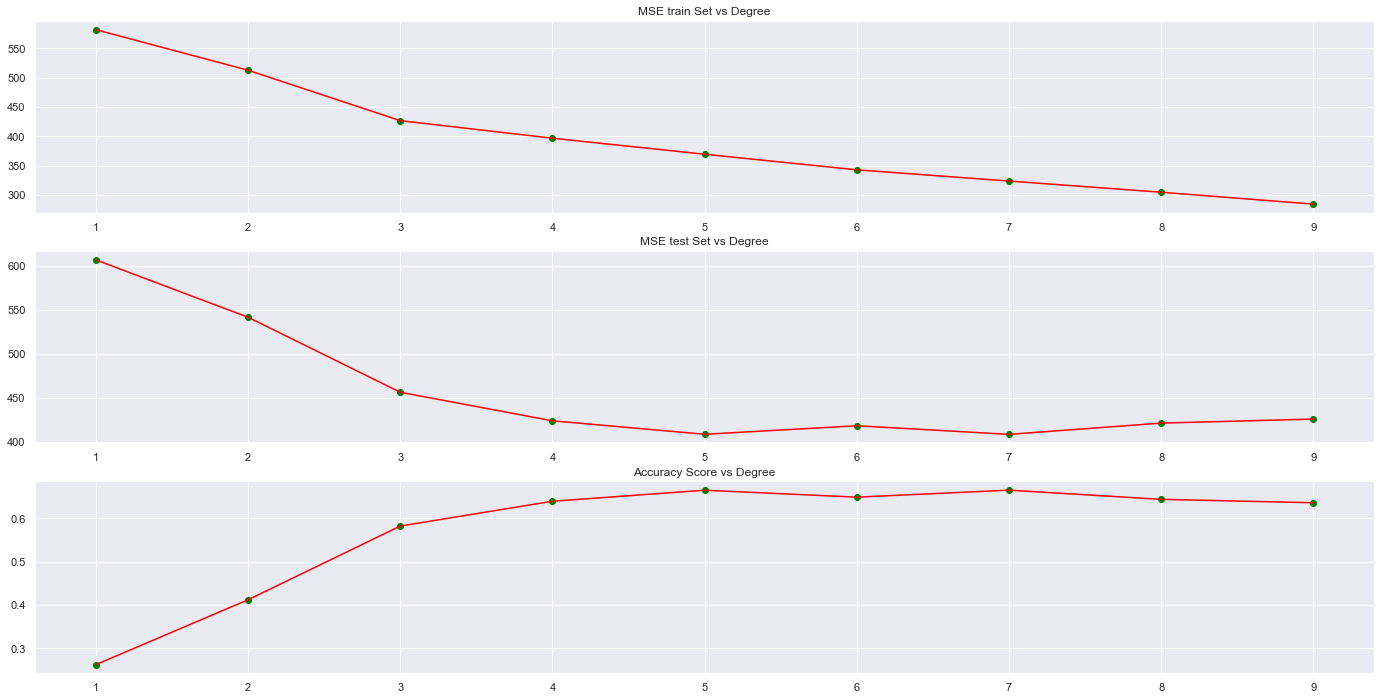

In [303]:
from sklearn.metrics import mean_squared_error
number_degrees = [1,2,3,4,5,6,7,8,9]    # Can add more inside but with higher degree, it might overfit the data 
MSE_TrainSet = []     # Empty list to store the MSE for train for each degree
MSE_TestSet = []      # Empty List to store the MSE for test for each degree
scores = []           # List to store the accuracy score for test set for each degree
for degree in number_degrees:
    print("Max_depth: ", degree)
    model = DecisionTreeRegressor(max_depth = degree)
    model.fit(X_train,y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    
    MSETrain = mean_squared_error(y_train, y_train_pred, squared=False)
    MSETest = mean_squared_error(y_test, y_test_pred, squared=False)
    
    scores.append(test_score)
    
    MSE_TrainSet.append(MSETrain)
    MSE_TestSet.append(MSETest)
    print("MSE train:\t", MSETrain)
    print("MSE test:\t", MSETest)
    print("train score:\t",train_score)
    print("test score: \t",test_score, "\n")
# Print MSE with different degree values
f, axes = plt.subplots(3, figsize=(24, 12))
axes[0].set_title("MSE train Set vs Degree")
axes[0].scatter(number_degrees,MSE_TrainSet, color="green")
axes[0].plot(number_degrees,MSE_TrainSet, color="red") 

axes[1].set_title("MSE test Set vs Degree")
axes[1].scatter(number_degrees,MSE_TestSet, color="green")
axes[1].plot(number_degrees,MSE_TestSet, color="red") 

axes[2].set_title("Accuracy Score vs Degree")
axes[2].scatter(number_degrees,scores, color="green")
axes[2].plot(number_degrees,scores, color="red") 

# auto calculated the lowest MSE degree on test set

# Take note here, this 2 should be the same index in order to determine that that might be the best degree
Best_Degree_MSE = MSE_TestSet.index(min(MSE_TestSet))+1
print("The lowest MSE degree: \t",Best_Degree_MSE)
Best_Degree_Score = scores.index(max(scores))+1
print("The highest Accuracy degree: \t",Best_Degree_Score)

In [289]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,20), dpi=300)
plot_tree(model, feature_names=X.columns);

In [290]:
y_train_pred = model.predict(X_train)
from sklearn.metrics import mean_squared_error
y_test_pred = model.predict(X_test)

train_score = model.score(X_train,y_train)
test_score = model.score(X_test,y_test)
    
MSETrain = mean_squared_error(y_train, y_train_pred, squared=False)
MSETest = mean_squared_error(y_test, y_test_pred, squared=False)

print("MSE train:\t", MSETrain)
print("MSE test:\t", MSETest)
print("train score:\t",train_score)
print("test score: \t",test_score, "\n")

MSE train:	 284.3381018753966
MSE test:	 405.5403905888829
train score:	 0.8333627174979134
test score: 	 0.6702978379726612 



In [291]:
# Another Method: Random Forest regressor
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn.metrics import accuracy_score
regressor = RandomForestRegressor()
regressor.fit(X_train,np.ravel(y_train))
y_predict = regressor.predict(X_test)
MSE = mean_squared_error(y_predict,y_test,squared = False)
score = regressor.score(X_test,y_test)
print("MSE: \n",MSE,"Score: ",score)
print("Parameters currently using: \n")
pprint(regressor.get_params())

MSE: 
 389.4830153168699 Score:  0.6958900624710224
Parameters currently using: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [292]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start= 10, stop = 1000, num = 10)]

max_features = ['auto','sqrt']

max_depth = [int(x) for x in np.linspace(10,110,num = 11)]
max_depth.append(None)

min_samples_split = [2,5,10]
min_samples_leaf = [1,2,4]
bootstrap = [True,False]
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [293]:
rf_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [294]:
rf_random.fit(X_train, np.ravel(y_train))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=42, verbose=2)

In [295]:
regressor.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [296]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 110,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 450}


In [297]:
best_random = rf_random.best_estimator_
y_predict = best_random.predict(X_test)

In [298]:
MSE = mean_squared_error(y_predict,y_test,squared = False)
score = best_random.score(X_test,y_test)
print("MSE: \n",MSE,"Score: ",score)

MSE: 
 381.3256770620804 Score:  0.7084952305105505


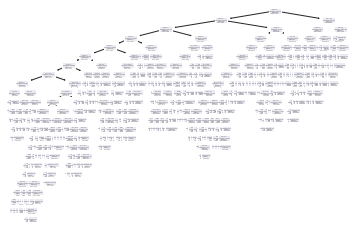

In [300]:
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=300)
tree.plot_tree(best_random.estimators_[0]);